# Example : entropy calculations

(c) Charles Le Losq and contributors, 2021-2024
see embedded licence file

In this notebook we show how one can use i-Melt to observe how a property like glass transition temperature changes with composition in a systematic way.

We focus on building contour maps of variations in entropy with SiO$_2$, Al$_2$O$_3$, and mixing 2 metal cations.

### Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt 

# import imelt
import imelt

# other essentials
import torch

# we will work on CPU there
device = imelt.get_default_device()
print(device)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/charleslelosq/anaconda3/envs/ml/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/charleslelosq/anaconda3/envs/ml/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/charleslelosq/anaconda3/envs/ml/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in st

CUDA AVAILABLE? 
No, setting device to cpu
cpu


### Loading dataset and models

In [2]:
# data are loaded using the data_loader helper.
ds = imelt.data_loader()

# The 10 models are loaded through a bagging class.
neuralmodel = imelt.load_pretrained_bagged(activation_function=torch.nn.GELU())

# Calculate glass transition temperature Tg for a single composition

In [3]:
X_SiO2 = imelt.generate_query_single(sio2=100.0)
sctg_SiO2  = neuralmodel.predict("tg", X_SiO2)
print("The configurational entropy at Tg is {:.1f} J/mol/K".format(sctg_SiO2[0]))

RuntimeError: Numpy is not available

We can calculate an error bar estimate for this value by querying several samples:

In [4]:
sctg_SiO2  = neuralmodel.predict("tg", X_SiO2, sampling=True, n_sample=50)

Here I queried 50 samples from 10 models so I have in total 500 samples, from which I can calculate statistics like the mean and standard deviation:

In [6]:
print("Mean value: {:.1f}".format(np.mean(sctg_SiO2)))
print("Standard deviation: {:.1f}".format(np.std(sctg_SiO2)))

Mean value: 1421.8
Standard deviation: 61.2


### Visualizing how Tg changes with composition

We can use the function `generate_query_range` to follow how Tg changes with melt composition.

Here we range from a simple sodium silicate glass to a complex Ca-Na aluminosilicate one for the sack of example:

Text(0, 0.5, 'Glass transition, K')

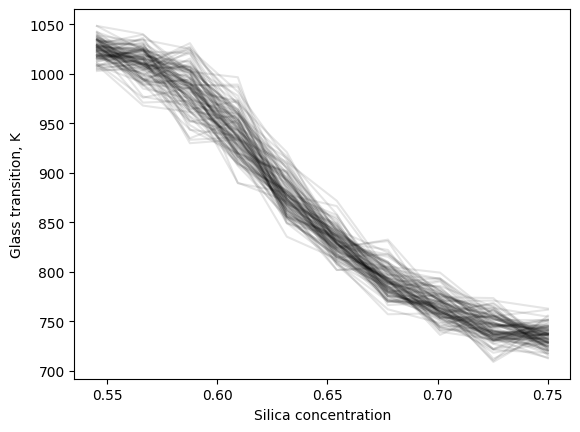

In [9]:
# below we generate compositions
Compo_ = {"sio2": [0.75, 0.60],
         "al2o3": [0.00, 0.20],
         "na2o" : [0.25, 0.10],
           "k2o": [0.00, 0.05],
           "mgo": [0.00, 0.05],
           "cao": [0.00, 0.10]}

X_in = imelt.generate_query_range(Compo_, nb_values=10)
tg_out  = neuralmodel.predict("tg", X_in.to_numpy(), sampling=True)

plt.figure()
plt.plot(X_in.sio2, tg_out, color="k", alpha=0.1)
plt.xlabel("Silica concentration")
plt.ylabel("Glass transition, K")

# Generating manually a more complex example

In [10]:

def generate_compo(sio2, R_MAl, cation1="na2o", cation2="k2o"):
    
    # First we check the cations that were selected
    if (cation1 == "na2o") & (cation2 == "k2o"):
        cation3 = "mgo"
        cation4 = "cao"
    elif (cation1 == "na2o") & (cation2 == "mgo"):
        cation3 = "k2o"
        cation4 = "cao"
    elif (cation1 == "na2o") & (cation2 == "cao"):
        cation3 = "k2o"
        cation4 = "mgo"
    elif (cation1 == "k2o") & (cation2 == "mgo"):
        cation3 = "na2o"
        cation4 = "cao"
    elif (cation1 == "k2o") & (cation2 == "cao"):
        cation3 = "na2o"
        cation4 = "mgo"
    elif (cation1 == "mgo") & (cation2 == "cao"):
        cation3 = "na2o"
        cation4 = "k2o"
    
    # generating starting arrays
    xk = np.linspace(0.,1.,500)
    out=np.zeros((len(sio2)*500,7))

    # Generating the initial dataframe
    for i in range(0,len(sio2)):
        out[i*500:(i+1)*500,0] = sio2[i] # first column is sio2
        out[i*500:(i+1)*500,-1] = xk # last column is xk

    master_df = pd.DataFrame(data=out, columns=["sio2","al2o3","na2o","k2o","mgo","cao","xk"])
    master_df.loc[:,'al2o3'] = R_MAl * (1.0 - master_df.loc[:,'sio2'])
    metals = 1.0 - master_df['sio2'] - master_df['al2o3']
    master_df[cation1] = (1.0-master_df.loc[:,"xk"])*metals
    master_df[cation2] = master_df.loc[:,"xk"]*metals
    master_df[cation3] = 0.0
    master_df[cation4] = 0.0

    return master_df




# SiO2 between 50 and 100% (nearly)
sio2_gen = np.arange(0.5,0.999,0.005)

# Na-K mixtures
X_gen_RS_nak_rec = generate_compo(sio2_gen, 0.00, cation1="na2o", cation2="k2o")
X_gen_R3_nak_rec = generate_compo(sio2_gen, 0.25, cation1="na2o", cation2="k2o")
X_gen_R1_nak_rec = generate_compo(sio2_gen, 0.50, cation1="na2o", cation2="k2o")

# Ca-Mg mixtures
X_gen_RS_camg_rec = generate_compo(sio2_gen, 0.00, cation1="mgo", cation2="cao")
X_gen_R3_camg_rec = generate_compo(sio2_gen, 0.25, cation1="mgo", cation2="cao")
X_gen_R1_camg_rec = generate_compo(sio2_gen, 0.50, cation1="mgo", cation2="cao")

### We now calculate the Tg.

In [11]:
sctg_RS_nak_rec  = neuralmodel.predict("tg",imelt.descriptors(X_gen_RS_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R3_nak_rec  = neuralmodel.predict("tg",imelt.descriptors(X_gen_R3_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R1_nak_rec  = neuralmodel.predict("tg",imelt.descriptors(X_gen_R1_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_RS_camg_rec = neuralmodel.predict("tg",imelt.descriptors(X_gen_RS_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R3_camg_rec = neuralmodel.predict("tg",imelt.descriptors(X_gen_R3_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())
sctg_R1_camg_rec = neuralmodel.predict("tg",imelt.descriptors(X_gen_R1_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())

### And we do a figure 

It plots contour maps of the entropy as a function of chemistry.

First line will be Na-K mixtures, second Ca-Mg ones.

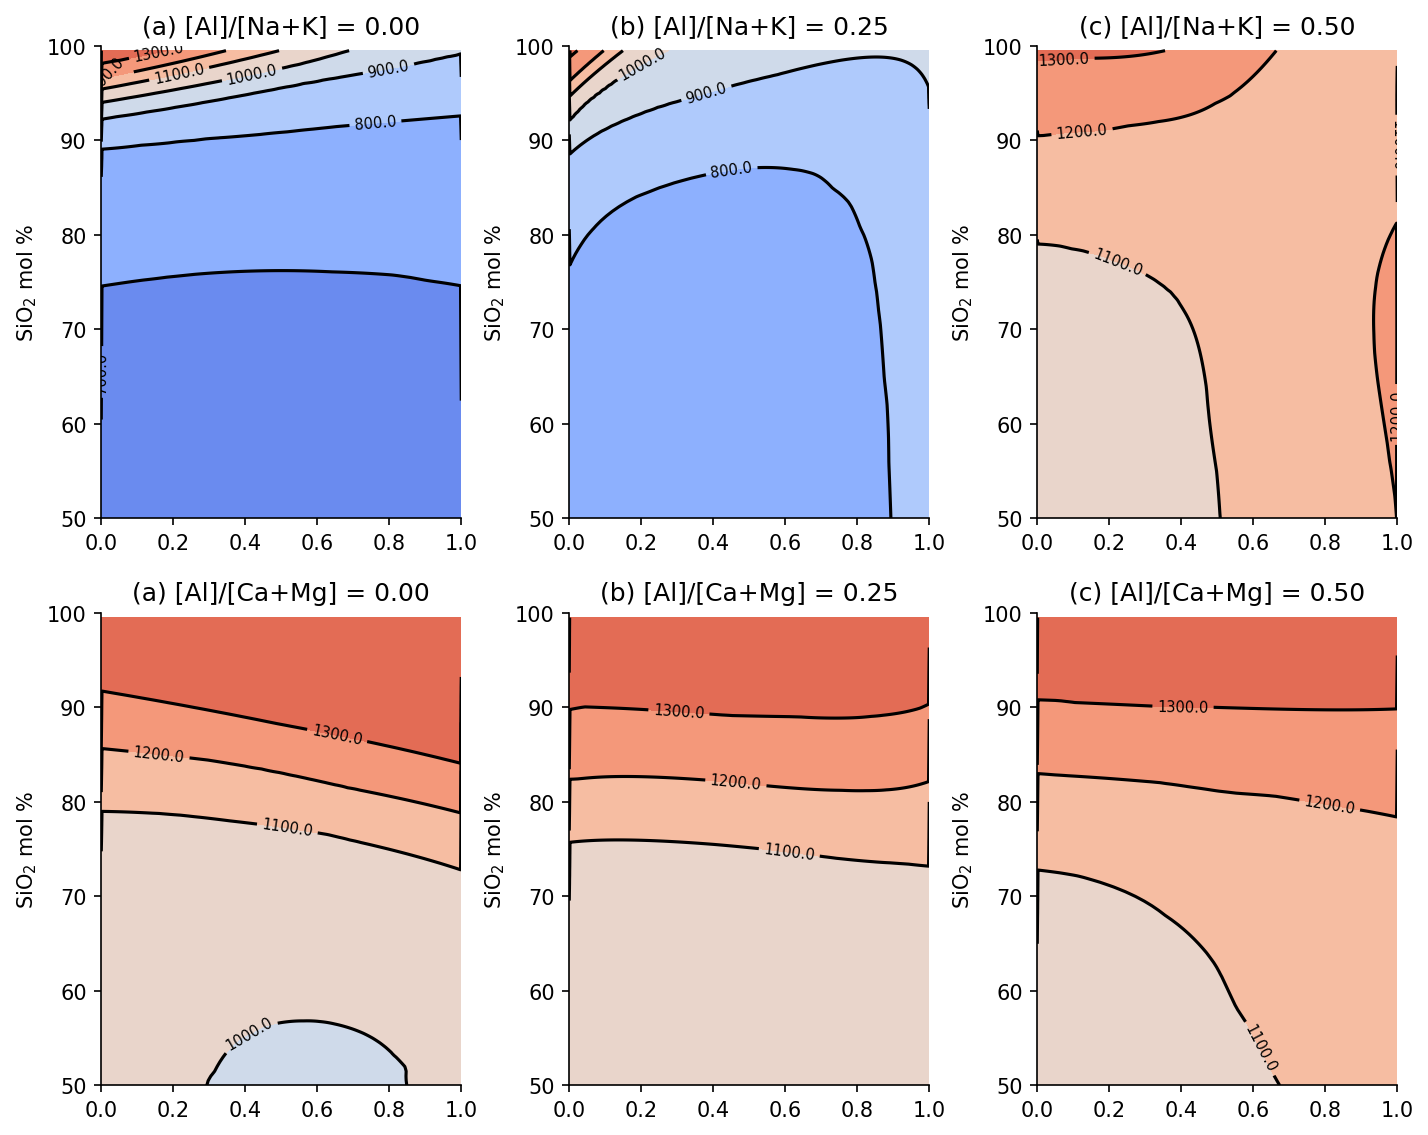

In [16]:
def entro_mix_fig(ax1, X, y, title_string, set_y_label=True,
                  norm = matplotlib.colors.Normalize(vmin=500,vmax=1500.0), # Manual setup
                    c_m = matplotlib.cm.coolwarm, # choose a colormap
                    levels = np.arange(500,1500,100),
                    levels_l = np.arange(500,1500,100)):
    """helper function for the figure"""
    
    s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure
    
    tc1 = ax1.tricontourf(X.loc[:,"xk"], 
                X.loc[:,"sio2"]*100, 
                y, 
                levels=levels, cmap=c_m, norm=norm)
    tc1_l = ax1.tricontour(X.loc[:,"xk"], 
                    X.loc[:,"sio2"]*100, 
                    y, 
                    levels=levels_l, colors='k', norm=norm)
    ax1.clabel(tc1_l, inline=1, fontsize=7, fmt="%1.1f")

    ax1.set_xlim(0,1)
    ax1.set_ylim(50,100.)

    if set_y_label == True:
        ax1.set_ylabel(r"SiO$_2$ mol %")

    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # Title
    ax1.set_title(title_string, loc='center')
    return ax1

#
# Figure generation
#

fig11 = plt.figure(figsize=(9,9), dpi=150, constrained_layout=False)

gs1 = fig11.add_gridspec(nrows=2, ncols=3, 
                        left=0.02, right=0.98,
                        #bottom = 0.55, top = 0.95,
                        wspace=0.3, hspace=0.2)
ax1 = fig11.add_subplot(gs1[0,0])
ax2 = fig11.add_subplot(gs1[0,1])
ax3 = fig11.add_subplot(gs1[0,2])
ax4 = fig11.add_subplot(gs1[1,0])
ax5 = fig11.add_subplot(gs1[1,1])
ax6 = fig11.add_subplot(gs1[1,2])

####
#### XK along near tectosilicate joint
####
ax1 = entro_mix_fig(ax1, X_gen_RS_nak_rec, sctg_RS_nak_rec, "(a) [Al]/[Na+K] = 0.00")
ax2 = entro_mix_fig(ax2, X_gen_R3_nak_rec, sctg_R3_nak_rec, "(b) [Al]/[Na+K] = 0.25")
ax3 = entro_mix_fig(ax3, X_gen_R1_nak_rec, sctg_R1_nak_rec, "(c) [Al]/[Na+K] = 0.50")
ax4 = entro_mix_fig(ax4, X_gen_RS_camg_rec, sctg_RS_camg_rec, "(a) [Al]/[Ca+Mg] = 0.00")
ax5 = entro_mix_fig(ax5, X_gen_R3_camg_rec, sctg_R3_camg_rec, "(b) [Al]/[Ca+Mg] = 0.25")
ax6 = entro_mix_fig(ax6, X_gen_R1_camg_rec, sctg_R1_camg_rec, "(c) [Al]/[Ca+Mg] = 0.50")

plt.show()

### That's it !

This example can be changed as needed, for instance plotting $S^{conf}(T_g)$ or density as a function of composition, or observing other mixtures like Na-Ca or Na-Mg, etc.